# Домашнее задание: LARS и варианты реализации многоклассовой классификации

## Задание 1: Реализация регрессии с наименьшими углами (LARS)
Регрессия с наименьшими углами (LARS) — это алгоритм регрессии, который выбирает признаки пошагово, что делает его подходящим для задач с большим количеством признаков. Цель — найти подмножество признаков, которые наилучшим образом объясняют целевую переменную.

- LARS начинается с нуля для всех коэффициентов.

- Алгоритм находит признак, наиболее коррелирующий с откликом, и обновляет коэффициент этого признака до его значения по методу наименьших квадратов, пока не будут включены все признаки или не выполнено условие остановки.

Тут можно прочитать подробнее про алгоритм работы https://www.geeksforgeeks.org/least-angle-regression-lars/

In [20]:
# hello?
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import Lars

class LARS:
    def __init__(self):
        self.bias_ = 0.0
    
    def fit(self, X, y):
        X = X.astype(float).copy()
        y = y.astype(float).copy()
        if X.size == 0 or y.size == 0:
            raise ValueError("X or y is empty. Cannot fit the model.")
        n_samples, n_features = X.shape
        if n_features == 0:
            raise ValueError("X has no features.")
        X_mean = X.mean(axis=0)
        y_mean = y.mean()
        X -= X_mean
        y -= y_mean
        coefs = np.zeros(n_features)
        residual = y.copy()
        active = []
        for _ in range(n_features):
            corr = X.T.dot(residual)
            j = np.argmax(np.abs(corr))
            if j in active:
                break
            active.append(j)

            X_active = X[:, active]
            beta_active = np.linalg.pinv(X_active).dot(y)
            for idx, feat in enumerate(active):
                coefs[feat] = beta_active[idx]
            residual = y - X.dot(coefs)
            
        self.coefs_ = coefs
        self.bias_ = y_mean - X_mean.dot(self.coefs_)
        
        
    def predict(self, X):
        return X.dot(self.coefs_) + self.bias_

X_train = np.array([[1], [2], [3], [4], [5]])
y_train = np.array([2, 3, 5, 7, 11])
model = LARS()
model.fit(X_train, y_train)
preds = model.predict(X_train)

In [30]:
# Проверки для проверки предсказаний
assert preds.shape == (5,), "Предсказания должны соответствовать количеству образцов"
#r2 = r2_score(y_train, preds)
# print(r2)
assert r2_score(y_train, preds) > 0.8, "R2 должна быть выше 0.8"

In [22]:
# Сравнение с реализацией из sklearn
sklearn_model = Lars()
sklearn_model.fit(X_train, y_train)
sklearn_preds = sklearn_model.predict(X_train)

# print(preds)
# print(sklearn_preds)
assert np.allclose(preds, sklearn_preds, rtol=1e-03), "Предсказания должны совпадать с реализацией sklearn"#

[ 1.2  3.4  5.6  7.8 10. ]
[ 1.2  3.4  5.6  7.8 10. ]


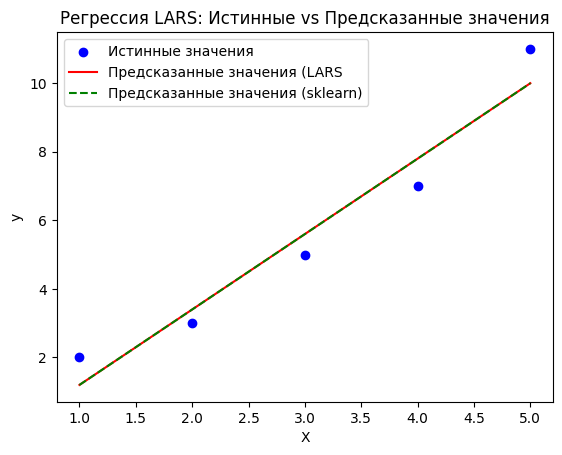

In [23]:
plt.scatter(X_train, y_train, color='blue', label="Истинные значения")
plt.plot(X_train, preds, color='red', label="Предсказанные значения (LARS")
plt.plot(X_train, sklearn_preds, color='green', linestyle='dashed', label="Предсказанные значения (sklearn)")
plt.legend()
plt.title("Регрессия LARS: Истинные vs Предсказанные значения")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## Задание 2: Классификация Один-против-Всех и Все-против-Всех с логистической регрессией
В многоклассовой классификации два популярных подхода:

- Один-против-Всех (OvA): Для каждого класса обучается отдельный классификатор, который отделяет этот класс от всех остальных.
- Все-против-Всех (AvA): Обучается классификатор для каждой пары классов.

https://education.yandex.ru/handbook/ml/article/linear-models#:~:text=%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F-,%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F,-%D0%92%20%D1%8D%D1%82%D0%BE%D0%BC%20%D1%80%D0%B0%D0%B7%D0%B4%D0%B5%D0%BB%D0%B5

In [25]:
def plot_ova_classifier(classifier, X, y):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    for i in np.unique(y):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], color=colors[i], label=f"Класс {i}")
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Z_probabilities = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Z = np.max(Z_probabilities, axis=1).reshape(xx.shape)
    
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')
    
    # plt.scatter(X[:, 0], X[:, 1], color='black')
    plt.title("One-vs-All")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    # plt.colorbar(label="Вероятность")
    plt.legend()
    plt.show()


def plot_ava_classifier(classifier, X, y):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red']
    for i in np.unique(y):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], color=colors[i], label=f"Класс {i}")
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Z_probabilities = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Z = np.max(Z_probabilities, axis=1).reshape(xx.shape)
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')
    
    # plt.scatter(X[:, 0], X[:, 1], color='black')
    plt.title("All-vs-All")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    # plt.colorbar(label="Вероятность")
    plt.legend()
    plt.show()

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

class OneVsAllClassifier:
    def __init__(self):
        self.models = []
        self.classes_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.models = []
        for c in self.classes_:
            y_binary = (y == c).astype(int)
            clf = LogisticRegression()
            clf.fit(X, y_binary)
            self.models.append(clf)
        return self

    def predict(self, X):
        X = np.asarray(X)
        scores = np.zeros((X.shape[0], len(self.classes_)))
        for idx, clf in enumerate(self.models):
            scores[:, idx] = clf.predict_proba(X)[:, 1]
        chosen = np.argmax(scores, axis=1)
        return self.classes_[chosen]

X_test = np.array([[1, 2], [4, 5], [7, 8], [2, 3], [5, 6]])
y_test = np.array([0, 1, 2, 0, 1])
ova_classifier = OneVsAllClassifier()
ova_classifier.fit(X_test, y_test)
ova_preds = ova_classifier.predict(X_test)

assert len(ova_preds) == len(X_test), "Предсказания должны соответствовать количеству образцов"
assert accuracy_score(y_test, ova_preds) > 0.8, "Точность должна быть выше 0.8"

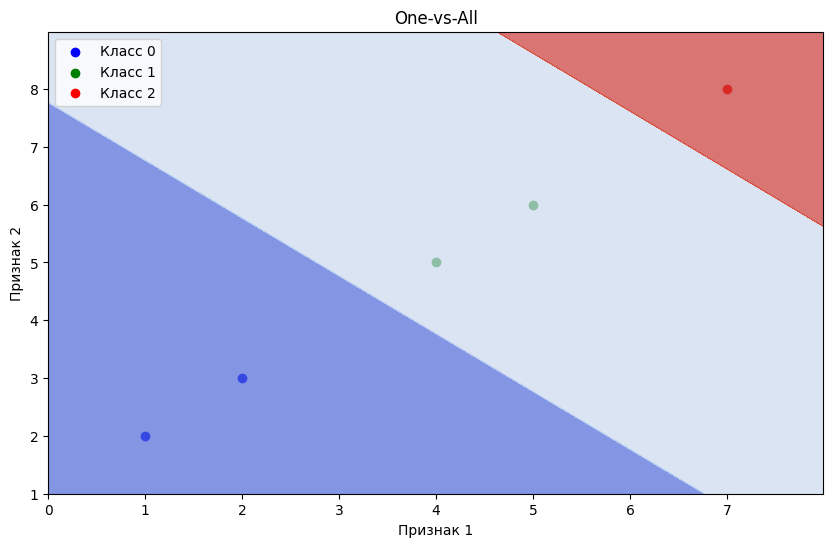

In [27]:
plot_ova_classifier(ova_classifier, X_test, y_test)

In [28]:
class AllVsAllClassifier:
    def __init__(self):
        self.pairwise_models = {}
        self.classes_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.pairwise_models = {}

        for i, ci in enumerate(self.classes_):
            for j, cj in enumerate(self.classes_):
                if cj <= ci:
                    continue
                mask = (y == ci) | (y == cj)
                X_pair = X[mask]
                y_pair = y[mask]
                clf = LogisticRegression()
                clf.fit(X_pair, y_pair)
                self.pairwise_models[(ci, cj)] = clf
        return self

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        vote_counts = np.zeros((n_samples, len(self.classes_)), dtype=int)
        for (ci, cj), clf in self.pairwise_models.items():
            preds = clf.predict(X)
            for k, p in enumerate(preds):
                cls_idx = np.where(self.classes_ == p)[0][0]
                vote_counts[k, cls_idx] += 1
        winners = np.argmax(vote_counts, axis=1)
        return self.classes_[winners]

ava_classifier = AllVsAllClassifier()
ava_classifier.fit(X_test, y_test)
ava_preds = ava_classifier.predict(X_test)

assert len(ava_preds) == len(X_test), "Предсказания должны соответствовать количеству образцов"
assert accuracy_score(y_test, ava_preds) > 0.8, "Точность должна быть выше 0.8"

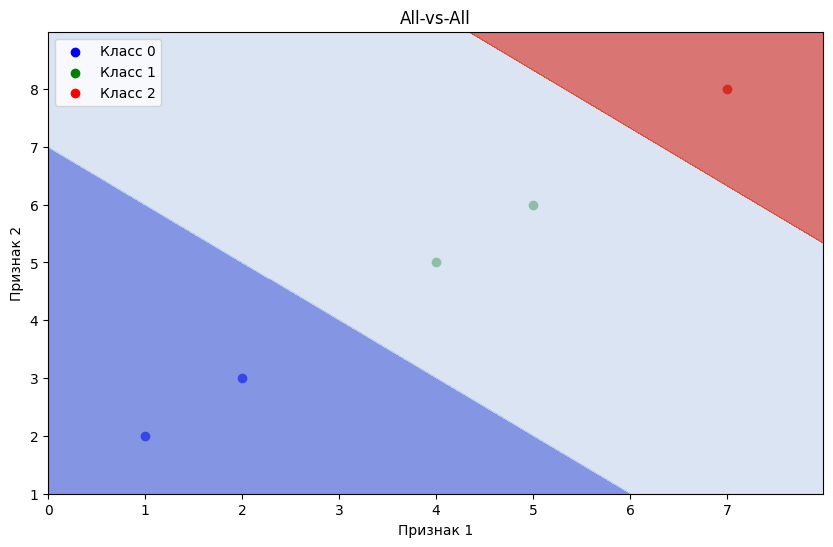

In [29]:
plot_ava_classifier(ava_classifier, X_test, y_test)